<h1 style="color:rgb(17, 116, 155);text-align:left;font-size:250%;font-family:verdana;text-decoration:underline;"> 
    Advanced topics - Final Project - Part 2: Image Retrieval</h1>

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import tensorflow as tf
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import faiss
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
#  **◊©◊ú◊ë 1: ◊ò◊¢◊ô◊†◊™ ◊î◊†◊™◊ï◊†◊ô◊ù (TFRecord) ◊ï◊î◊õ◊†◊î ◊ú◊§◊ï◊®◊û◊ò PyTorch**
print(" Loading Cars196 dataset from TFRecord files...")

data_dir = r"C:\Users\revit\Documents\Data Learning\cars196"

#  ◊ô◊¶◊ô◊®◊™ ◊®◊©◊ô◊û◊™ ◊ß◊ë◊¶◊ô ◊î-TFRecord
train_files = [os.path.join(data_dir, f"cars196-train.tfrecord-0000{i}-of-00008") for i in range(8)]
test_files = [os.path.join(data_dir, f"cars196-test.tfrecord-0000{i}-of-00008") for i in range(8)]

#  ◊§◊ï◊†◊ß◊¶◊ô◊î ◊ú◊ß◊®◊ô◊ê◊™ TFRecord
# ◊û◊í◊ì◊ô◊® ◊ê◊ô◊ú◊ï ◊™◊õ◊ï◊†◊ï◊™ ◊ß◊ô◊ô◊û◊ï◊™ ◊ë◊õ◊ú ◊ì◊ï◊í◊û◊î: ◊™◊û◊ï◊†◊î (◊ë◊§◊ï◊®◊û◊ò ◊û◊ó◊®◊ï◊ñ◊™) ◊ï◊™◊ï◊ï◊ô◊™ (int64).
def parse_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    # ◊û◊§◊¢◊†◊ó ◊ê◊™ ◊î◊ì◊ï◊í◊û◊î ◊ë◊î◊™◊ê◊ù ◊ú◊û◊ê◊§◊ô◊ô◊†◊ô◊ù ◊©◊î◊ï◊í◊ì◊®◊ï.
    parsed_example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(parsed_example['image'], channels=3)
    image = tf.image.resize(image, (224, 224)) # ◊û◊©◊†◊î ◊ê◊™ ◊í◊ï◊ì◊ú ◊î◊™◊û◊ï◊†◊î ◊ú◊í◊ï◊ì◊ú 224x224 ◊©◊û◊™◊ê◊ô◊ù ◊ú-ResNet50.
    label = parsed_example['label']
    return image, label # ◊û◊ó◊ñ◊ô◊® ◊ê◊™ ◊î◊™◊û◊ï◊†◊î ◊ï◊î◊™◊ï◊ï◊ô◊™.

# ◊§◊ï◊†◊ß◊¶◊ô◊î ◊©◊ß◊ï◊®◊ê◊™ ◊ß◊ë◊¶◊ô◊ù ◊ï◊û◊û◊§◊î ◊õ◊ú ◊ì◊ï◊í◊û◊î ◊ú◊§◊ï◊®◊û◊ò ◊©◊ú (◊™◊û◊ï◊†◊î, ◊™◊ï◊ï◊ô◊™), ◊ï◊ê◊ñ ◊û◊ó◊ñ◊ô◊®◊î ◊®◊©◊ô◊û◊î.
def load_tfrecord_dataset(filenames):
    raw_dataset = tf.data.TFRecordDataset(filenames)
    dataset = raw_dataset.map(parse_tfrecord)
    return list(dataset)  # ◊û◊û◊ô◊®◊ô◊ù ◊ú◊®◊©◊ô◊û◊î ◊ú◊©◊ô◊û◊ï◊© ◊ë-PyTorch

#  ◊ò◊¢◊ô◊†◊™ ◊î-Train/Test ◊û-TFRecord
# ◊û◊û◊ô◊®◊ô◊ù ◊ê◊™ ◊õ◊ú ◊î◊™◊û◊ï◊†◊ï◊™ ◊ú◊§◊ï◊®◊û◊ò NumPy ◊ë◊í◊ï◊ì◊ú ◊û◊™◊ê◊ô◊ù, ◊õ◊ì◊ô ◊ú◊î◊©◊™◊û◊© ◊ë◊î◊ü ◊¢◊ù PyTorch ◊ë◊î◊û◊©◊ö.
train_data = [(image.numpy().astype('uint8'), label.numpy()) for image, label in load_tfrecord_dataset(train_files)]
test_data = [(image.numpy().astype('uint8'), label.numpy()) for image, label in load_tfrecord_dataset(test_files)]

print(f" Loaded {len(train_data)} training images and {len(test_data)} test images.")


üîπ Loading Cars196 dataset from TFRecord files...
‚úÖ Loaded 8144 training images and 8041 test images.


In [4]:
#  **◊©◊ú◊ë 2: ◊ô◊¶◊ô◊®◊™ ◊û◊ó◊ú◊ß◊™ Dataset ◊û◊ï◊™◊ê◊û◊™ ◊ú-PyTorch**
class Cars196Dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform # ◊û◊í◊ì◊ô◊® ◊û◊ó◊ú◊ß◊î ◊©◊û◊®◊ó◊ô◊ë◊î ◊ê◊™ Dataset ◊©◊ú PyTorch. ◊û◊ß◊ë◊ú◊™ ◊ì◊ê◊ò◊î (◊®◊©◊ô◊û◊™ ◊™◊û◊ï◊†◊ï◊™) ◊ï◊ò◊®◊†◊°◊§◊ï◊®◊û◊¶◊ô◊ï◊™.

    def __len__(self):
        return len(self.data) # ◊û◊ó◊ñ◊ô◊®◊î ◊ê◊™ ◊õ◊û◊ï◊™ ◊î◊ì◊ï◊í◊û◊ê◊ï◊™.

    def __getitem__(self, idx):
        image_np, label = self.data[idx]
        image = Image.fromarray(image_np)
        if self.transform:
            image = self.transform(image)
        return image, label # ◊û◊ó◊ñ◊ô◊®◊î ◊ê◊™ ◊î◊ì◊ï◊í◊û◊î ◊ú◊§◊ô ◊ê◊ô◊†◊ì◊ß◊°, ◊õ◊ï◊ú◊ú ◊ò◊®◊†◊°◊§◊ï◊®◊û◊¶◊ô◊î ◊ê◊ù ◊î◊ï◊í◊ì◊®◊î.

In [5]:
#  **◊©◊ú◊ë 3: ◊î◊í◊ì◊®◊™ ◊ò◊®◊†◊°◊§◊ï◊®◊û◊¶◊ô◊ï◊™ ◊ú◊†◊™◊ï◊†◊ô◊ù**
print("üîπ Applying transformations to the dataset...")

# ◊û◊™◊ó◊ô◊ú◊ô◊ù ◊ú◊ë◊†◊ï◊™ ◊®◊¶◊£ ◊©◊ú ◊ò◊®◊†◊°◊§◊ï◊®◊û◊¶◊ô◊ï◊™ ◊©◊û◊ï◊§◊¢◊ú◊ï◊™ ◊¢◊ú ◊õ◊ú ◊™◊û◊ï◊†◊î ◊ë◊°◊ò ◊î◊ê◊ô◊û◊ï◊ü.
train_transform = transforms.Compose([ 
    transforms.RandomHorizontalFlip(),    # ◊î◊ï◊§◊ö ◊ê◊™ ◊î◊™◊û◊ï◊†◊î ◊ë◊ê◊ï◊§◊ü ◊ê◊ß◊®◊ê◊ô ◊û◊¶◊ì ◊ô◊û◊ô◊ü ◊ú◊©◊û◊ê◊ú (◊õ◊û◊ï ◊û◊®◊ê◊î).
    transforms.RandomRotation(10),     # ◊û◊°◊ï◊ë◊ë ◊ê◊™ ◊î◊™◊û◊ï◊†◊î ◊ë◊ñ◊ï◊ï◊ô◊™ ◊ê◊ß◊®◊ê◊ô◊™ ◊ë◊ô◊ü -10¬∞ ◊ú-10¬∞.
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),    # ◊ó◊ï◊™◊ö ◊ó◊ú◊ß ◊ê◊ß◊®◊ê◊ô ◊û◊î◊™◊û◊ï◊†◊î (◊ë◊ô◊ü 80% ◊ú-100% ◊û◊î◊©◊ò◊ó), ◊ï◊ê◊ñ ◊û◊©◊†◊î ◊ú◊í◊ï◊ì◊ú 224√ó224.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),     # ◊û◊©◊†◊î ◊ë◊î◊í◊®◊ú◊î ◊ê◊™ ◊î◊ë◊î◊ô◊®◊ï◊™, ◊†◊ô◊í◊ï◊ì◊ô◊ï◊™, ◊®◊ï◊ï◊ô◊î ◊¶◊ë◊¢◊ï◊†◊ô◊™ , ◊í◊ï◊ï◊†◊ô◊ù
    transforms.ToTensor(),    # ◊û◊û◊ô◊® ◊ê◊™ ◊î◊™◊û◊ï◊†◊î ◊û◊§◊ï◊®◊û◊ò PIL (◊ê◊ï numpy) ◊ú◊ò◊†◊ñ◊ï◊® ◊©◊ú PyTorch.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # ◊û◊†◊®◊û◊ú ◊õ◊ú ◊¢◊®◊ï◊• ◊¶◊ë◊¢ (R, G, B) ◊ú◊§◊ô ◊û◊û◊ï◊¶◊¢◊ô◊ù ◊ï◊°◊ò◊ô◊ï◊™ ◊™◊ß◊ü ◊©◊ú ImageNet.
# ◊ú◊ï◊ï◊ì◊ê ◊©◊î◊™◊û◊ï◊†◊ï◊™ ◊™◊ï◊ê◊û◊ï◊™ ◊ú◊û◊î ◊©◊î◊û◊ï◊ì◊ú ◊î◊û◊ê◊ï◊û◊ü ◊¢◊ú ImageNet ◊û◊¶◊§◊î ◊ú◊ß◊ë◊ú.

])
# ◊û◊í◊ì◊ô◊® ◊®◊¶◊£ ◊©◊ú ◊§◊¢◊ï◊ú◊ï◊™ ◊ú◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î ◊ë◊ê◊ô◊û◊ï◊ü: ◊§◊ú◊ô◊§, ◊°◊ô◊ë◊ï◊ë, ◊ó◊ô◊™◊ï◊ö, ◊î◊™◊ê◊û◊ï◊™ ◊¶◊ë◊¢◊ô◊ù, ◊ï◊î◊û◊®◊î ◊ú-Tensor.

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# ◊¢◊ë◊ï◊® ◊î◊ë◊ì◊ô◊ß◊î ◊¢◊ï◊©◊ô◊ù ◊®◊ß ◊î◊û◊®◊î ◊ú-Tensor ◊ï◊†◊ô◊®◊û◊ï◊ú (◊ú◊ú◊ê ◊ê◊ï◊í◊û◊†◊ò◊¶◊ô◊î).
#◊î◊û◊ò◊®◊î ◊ú◊ë◊ì◊ï◊ß ◊ê◊™ ◊î◊û◊ï◊ì◊ú ◊ë◊™◊†◊ê◊ô◊ù "◊†◊ß◊ô◊ô◊ù" ◊õ◊û◊ï ◊™◊û◊ï◊†◊ï◊™ ◊ê◊û◊ô◊™◊ô◊ï◊™ ◊ë◊¢◊ï◊ú◊ù ◊î◊ê◊û◊ô◊™◊ô.

üîπ Applying transformations to the dataset...


In [6]:
#  **◊©◊ú◊ë 4: ◊ô◊¶◊ô◊®◊™ DataLoaders**
batch_size = 32    # ◊ë◊õ◊ú ◊©◊ú◊ë ◊ê◊ô◊û◊ï◊ü, ◊†◊ò◊¢◊†◊ï◊™ 32 ◊™◊û◊ï◊†◊ï◊™ + ◊™◊ï◊ï◊ô◊ï◊™.

# ◊ô◊ï◊¶◊®◊ô◊ù ◊ê◊™ ◊î◊ì◊ê◊ò◊ê◊°◊ò◊ô◊ù ◊©◊ú◊ö (Dataset) ◊ú-Train ◊ï-Test.
# ◊õ◊ú ◊ê◊ó◊ì ◊û◊î◊ù ◊ô◊ï◊ì◊¢ ◊ú◊î◊ó◊ñ◊ô◊® ◊™◊û◊ï◊†◊î ◊ï◊™◊ô◊ï◊í ◊ú◊§◊ô ◊ê◊ô◊†◊ì◊ß◊°, ◊¢◊ù ◊î◊ò◊®◊†◊°◊§◊ï◊®◊û◊¶◊ô◊ï◊™
train_dataset = Cars196Dataset(train_data, transform=train_transform)
test_dataset = Cars196Dataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# shuffle=True ‚Äì ◊û◊¢◊®◊ë◊ë ◊ê◊™ ◊î◊†◊™◊ï◊†◊ô◊ù ◊ë◊õ◊ú epoch (◊û◊ê◊ï◊ì ◊ó◊©◊ï◊ë ◊ú◊û◊†◊ï◊¢ ◊î◊ò◊ô◊ï◊™ ◊ë◊ê◊ô◊û◊ï◊ü).

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# ◊ë◊ú◊ô shuffle ‚Äì ◊õ◊ô ◊ë◊ñ◊û◊ü ◊ë◊ì◊ô◊ß◊î ◊®◊ï◊¶◊ô◊ù ◊¢◊ß◊ë◊ô◊ï◊™ ◊ï◊ú◊ê ◊¢◊®◊ë◊ï◊ë.
# num_workers=0 ‚Äì ◊ß◊ï◊ë◊¢ ◊õ◊û◊î ◊™◊î◊ú◊ô◊õ◊ô◊ù (processes) ◊ô◊ò◊¢◊†◊ï ◊ë◊û◊ß◊ë◊ô◊ú ◊ê◊™ ◊î◊ì◊ê◊ò◊î.

print(f" Train and Test Dataloaders created with batch size {batch_size}.")


‚úÖ Train and Test Dataloaders created with batch size 32.


In [7]:
#  **◊©◊ú◊ë 5: ◊ò◊¢◊ô◊†◊™ ◊û◊ï◊ì◊ú ResNet50 ◊¢◊ù ◊î◊™◊ê◊û◊ï◊™**
print("üîπ Initializing ResNet50 model...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # ◊ò◊ï◊¢◊ü ◊ê◊™ ◊î◊û◊ï◊ì◊ú ResNet50 ◊¢◊ù ◊û◊©◊ß◊ú◊ô◊ù ◊û◊ê◊ï◊û◊†◊ô◊ù ◊û◊®◊ê◊© ◊¢◊ú ImageNet
num_features = model.fc.in_features # ◊ó◊ô◊ú◊ï◊• ◊û◊°◊§◊® ◊î◊§◊ô◊¶'◊®◊ô◊ù ◊û◊î◊©◊õ◊ë◊î ◊î◊ê◊ó◊®◊ï◊†◊î ◊ú◊§◊†◊ô ◊î◊°◊ô◊ï◊ï◊í
# ◊ë◊ï◊ì◊ß◊ô◊ù ◊õ◊û◊î ◊§◊ô◊¶'◊®◊ô◊ù ◊ô◊ï◊¶◊ê◊ô◊ù ◊û◊î÷æResNet (◊ñ◊î in_features ◊©◊ú fc).◊ï◊ê◊ñ ◊û◊©◊™◊û◊©◊ô◊ù ◊ë◊û◊°◊§◊® ◊î◊ñ◊î ◊õ◊ì◊ô ◊ú◊ë◊†◊ï◊™ ◊©◊õ◊ë◊™ Linear ◊ó◊ì◊©◊î ◊û◊©◊ú◊†◊ï

#  ◊ì◊ô◊û◊ï◊ô ◊§◊©◊ï◊ò: ◊î◊®◊©◊™ ◊î◊ô◊ê ◊§◊° ◊ô◊ô◊¶◊ï◊®, ◊õ◊ú ◊™◊û◊ï◊†◊î ◊ô◊ï◊¶◊ê◊™ ◊û◊û◊†◊ï ◊¢◊ù 2048 ◊û◊ê◊§◊ô◊ô◊†◊ô◊ù,
# ◊¢◊õ◊©◊ô◊ï ◊®◊ï◊¶◊ô◊ù ◊ú◊î◊ó◊ú◊ô◊ò ◊ú◊ê◊ô◊ñ◊ï ◊û◊ó◊ú◊ß◊î (class) ◊î◊ô◊ê ◊©◊ô◊ô◊õ◊™.
# ◊ê◊ñ ◊ë◊ï◊†◊ô◊ù ◊©◊ú◊ë ◊ê◊ó◊®◊ï◊ü ◊ó◊ì◊© ◊ë◊§◊° ◊î◊ô◊ô◊¶◊ï◊®, ◊©◊û◊™◊ê◊ô◊ù ◊ú÷æ2048 ◊õ◊†◊ô◊°◊ï◊™ ◊ï÷æ196 ◊ô◊¶◊ô◊ê◊ï◊™ (◊û◊°◊§◊® ◊î◊ß◊ò◊í◊ï◊®◊ô◊ï◊™ ◊©◊ú◊†◊ï).

#◊î◊ó◊ú◊§◊™ ◊©◊õ◊ë◊™ ◊î◊°◊ô◊ï◊ï◊í
model.fc = nn.Sequential(
    nn.Dropout(0.5),   # ◊û◊õ◊ë◊î 50% ◊û◊î◊†◊ï◊ô◊®◊ï◊†◊ô◊ù ◊ë◊ê◊ô◊û◊ï◊ü (◊ë◊ê◊ß◊®◊ê◊ô) ‚Äì ◊õ◊ì◊ô ◊ú◊û◊†◊ï◊¢ Overfitting.
    nn.Linear(num_features, len(set(label for _, label in train_data)))  
# Linear() - ◊ô◊ï◊¶◊® ◊©◊õ◊ë◊î ◊ó◊ì◊©◊î ◊©◊û◊û◊§◊î ◊û÷æ2048 ◊§◊ô◊¶'◊®◊ô◊ù (◊ê◊ï ◊õ◊û◊î ◊©◊ô◊©) ◊ú÷æ196 ◊û◊ó◊ú◊ß◊ï◊™, ◊©◊ñ◊î ◊û◊°◊§◊® ◊î◊ß◊ò◊í◊ï◊®◊ô◊ï◊™ ◊©◊ú ◊®◊õ◊ë◊ô◊ù ◊ë÷æCars196.
# len() - ◊û◊ó◊©◊ë ◊ê◊™ ◊û◊°◊§◊® ◊î◊ß◊ò◊í◊ï◊®◊ô◊ï◊™ ◊î◊ô◊ô◊ó◊ï◊ì◊ô◊ï◊™ (labels ◊©◊ï◊†◊ô◊ù) ◊ë÷æTrain Set.
)
model = model.to(device)

print(" Model initialized and moved to", device)

üîπ Initializing ResNet50 model...
‚úÖ Model initialized and moved to cpu


In [8]:
#  **◊©◊ú◊ë 6: ◊§◊ï◊†◊ß◊¶◊ô◊ô◊™ ◊î◊§◊°◊ì ◊ï◊ê◊ï◊§◊ò◊ô◊û◊ô◊ñ◊¶◊ô◊î**
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4) # ◊î◊ê◊ï◊§◊ò◊ô◊û◊ô◊ô◊ñ◊® ◊ê◊ó◊®◊ê◊ô ◊ú◊¢◊ì◊õ◊ü ◊ê◊™ ◊î◊û◊©◊ß◊ú◊ô◊ù ◊©◊ú ◊î◊û◊ï◊ì◊ú ◊ú◊§◊ô ◊î◊í◊®◊ì◊ô◊ê◊†◊ò◊ô◊ù ◊©◊ó◊ï◊©◊ë◊ï.
# model.parameters()-	◊õ◊ú ◊î◊û◊©◊ß◊ú◊ô◊ù ◊©◊¶◊®◊ô◊ö ◊ú◊¢◊ì◊õ◊ü ◊ë◊û◊ï◊ì◊ú.
# Learning Rate ‚Äì ◊õ◊û◊î ◊ú◊©◊†◊ï◊™ ◊õ◊ú ◊§◊¢◊ù ◊ê◊™ ◊î◊û◊©◊ß◊ú◊ô◊ù (◊ß◊¶◊ë ◊î◊ú◊û◊ô◊ì◊î).
# momentum=0.9-	◊¢◊ï◊ñ◊® ◊ú◊î◊™◊í◊ë◊® ◊¢◊ú ◊®◊¢◊© ◊ï◊ú◊ß◊ë◊ú ◊¢◊ì◊õ◊ï◊†◊ô◊ù ◊ô◊¶◊ô◊ë◊ô◊ù ◊ô◊ï◊™◊® ‚Äì ◊ñ◊ï◊õ◊® ◊ê◊™ ◊î◊õ◊ô◊ï◊ï◊ü ◊©◊ú ◊î◊¶◊¢◊ì ◊î◊ß◊ï◊ì◊ù.
# weight_decay-	◊°◊ï◊í ◊©◊ú ◊®◊í◊ï◊ú◊®◊ô◊ñ◊¶◊ô◊î ‚Äì ◊¢◊ï◊ñ◊® ◊ú◊î◊ô◊û◊†◊¢ ◊û-overfitting ◊¢◊ú ◊ô◊ì◊ô "◊¢◊ï◊†◊©" ◊¢◊ú ◊û◊©◊ß◊ú◊ô◊ù ◊í◊ì◊ï◊ú◊ô◊ù ◊û◊ì◊ô.

In [9]:
import gc
import torch

torch.cuda.empty_cache()  # ◊ê◊ù ◊ô◊© GPU (◊ú◊ê ◊ê◊¶◊ú◊ö)
gc.collect()  # ◊†◊ô◊ß◊ï◊ô ◊ñ◊ô◊õ◊®◊ï◊ü ◊ë◊§◊ô◊ô◊™◊ï◊ü
# ◊û◊©◊ó◊®◊®◊ô◊ù ◊ñ◊ô◊õ◊®◊ï◊ü ◊ú◊ê ◊†◊ó◊ï◊•

377

In [10]:
#  **◊©◊ú◊ë 7: ◊ê◊ô◊û◊ï◊ü ◊î◊®◊©◊™ ◊¢◊ù Early Stopping**
print("üîπ Starting model training...")

num_epochs = 10
best_test_acc = 0.0
patience = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    print(f" Epoch {epoch+1}/{num_epochs} started.")  

    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Processing Batch {batch_idx}/{len(train_loader)}...")  # ◊î◊ì◊§◊°◊™ ◊°◊ò◊ò◊ï◊°

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # ◊ê◊ô◊§◊ï◊° ◊í◊®◊ì◊ô◊ê◊†◊ò◊ô◊ù
        outputs = model(images)   # ◊§◊ú◊ò ◊î◊û◊ï◊ì◊ú
        loss = criterion(outputs, labels)  # ◊ó◊ô◊©◊ï◊ë ◊î◊§◊°◊ì
        loss.backward()  # ◊ó◊ô◊©◊ï◊ë ◊í◊®◊ì◊ô◊ê◊†◊ò◊ô◊ù
        optimizer.step()   # ◊¢◊ì◊õ◊ï◊ü ◊î◊û◊©◊ß◊ú◊ô◊ù

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # ◊ë◊ï◊ó◊® ◊ê◊™ ◊î◊û◊ó◊ú◊ß◊î ◊¢◊ù ◊î◊î◊°◊™◊ë◊®◊ï◊™ ◊î◊í◊ë◊ï◊î◊î ◊ë◊ô◊ï◊™◊® ◊û◊™◊ï◊ö ◊î◊§◊ú◊ò◊ô◊ù ◊©◊ú ◊î◊û◊ï◊ì◊ú.
        correct += (predicted == labels).sum().item()  # ◊°◊ï◊§◊® ◊õ◊û◊î ◊†◊ô◊ó◊ï◊©◊ô◊ù ◊î◊ô◊ï ◊†◊õ◊ï◊†◊ô◊ù.
        total += labels.size(0)

        if batch_idx % 10 == 0:
            print(f" Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

    #  ◊©◊û◊ô◊®◊™ Checkpoint ◊õ◊ú 50 ◊ë◊ê◊¶'◊ô◊ù
    if batch_idx % 50 == 0 and batch_idx > 0:  
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}_batch_{batch_idx}.pth")
        print(f" Model checkpoint saved at epoch {epoch+1}, batch {batch_idx}")
    
    train_accuracy = correct / total  # ◊û◊ó◊©◊ë ◊ì◊ô◊ï◊ß ◊õ◊ï◊ú◊ú ◊ú÷æTrain Set.
    print(f"\n Epoch {epoch+1}/{num_epochs} Completed!")
    print(f"üîπ Average Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

#  ◊©◊ú◊ë 8: ◊ë◊ì◊ô◊ß◊™ ◊ì◊ô◊ï◊ß ◊¢◊ú ◊î-Test ◊ê◊ó◊®◊ô ◊õ◊ú epoch
    print("üîπ Evaluating on Test Set...")
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():  # ◊ë◊ì◊ô◊ß◊î ◊ë◊ú◊ô ◊í◊®◊ì◊ô◊ê◊†◊ò◊ô◊ù ◊õ◊ô ◊ú◊ê ◊û◊ê◊û◊†◊ô◊ù ◊¢◊õ◊©◊ô◊ï.
        for images, labels in test_loader:
            print(f"üîπ Evaluating Batch {batch_idx}/{len(test_loader)}...")  # ◊î◊ì◊§◊°◊™ ◊°◊ò◊ò◊ï◊°
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    print(f" Test Accuracy after epoch {epoch+1}: {test_accuracy:.4f}")

    #  Early Stopping
    if test_accuracy > best_test_acc:
        best_test_acc = test_accuracy
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(" Best model saved!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(" Early stopping triggered. Training stopped.")
            break

print(" Training Completed!")

üîπ Starting model training...
‚úÖ Epoch 1/10 started.
Processing Batch 0/255...
‚úÖ Epoch 1/10, Batch 0/255, Loss: 5.3063
Processing Batch 1/255...
Processing Batch 2/255...
Processing Batch 3/255...
Processing Batch 4/255...
Processing Batch 5/255...
Processing Batch 6/255...
Processing Batch 7/255...
Processing Batch 8/255...
Processing Batch 9/255...
Processing Batch 10/255...
‚úÖ Epoch 1/10, Batch 10/255, Loss: 5.3023
Processing Batch 11/255...
Processing Batch 12/255...
Processing Batch 13/255...
Processing Batch 14/255...
Processing Batch 15/255...
Processing Batch 16/255...
Processing Batch 17/255...
Processing Batch 18/255...
Processing Batch 19/255...
Processing Batch 20/255...
‚úÖ Epoch 1/10, Batch 20/255, Loss: 5.3132
Processing Batch 21/255...
Processing Batch 22/255...
Processing Batch 23/255...
Processing Batch 24/255...
Processing Batch 25/255...
Processing Batch 26/255...
Processing Batch 27/255...
Processing Batch 28/255...
Processing Batch 29/255...
Processing Batch

In [36]:
#  **◊ò◊¢◊ô◊†◊™ ◊î◊û◊ï◊ì◊ú ◊î◊û◊ê◊ï◊û◊ü**
model_path = r"C:\Users\revit\Documents\Data Learning\Project2\best_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # ◊ò◊ï◊¢◊ü ◊ê◊™ ◊û◊ï◊ì◊ú ResNet50 ◊¢◊ù ◊û◊©◊ß◊ú◊ô◊ù ◊ò◊®◊ï◊ù-◊û◊ê◊ï◊û◊†◊ô◊ù ◊û÷æImageNet.
# ◊©◊û◊®◊†◊ï ◊®◊ß ◊ê◊™ ◊î◊û◊©◊ß◊ú◊ô◊ù ◊©◊ú ◊î◊û◊ï◊ì◊ú ◊ê◊ë◊ú ◊ú◊ê ◊©◊û◊®◊†◊ï ◊ê◊™ ◊î◊û◊ë◊†◊î ◊©◊ú ◊î◊û◊ï◊ì◊ú ◊¢◊¶◊û◊ï ◊ï◊ú◊õ◊ü ◊¶◊®◊ô◊ö ◊ú◊ë◊†◊ï◊™ ◊ê◊™ ◊î◊û◊ó◊ï◊ì◊© ◊û◊ó◊ì◊© ◊õ◊ì◊ô ◊©◊§◊ô◊ô◊ò◊ï◊®◊•' ◊ô◊ì◊¢ ◊ê◊ô◊§◊î ◊ú◊©◊ô◊ù ◊ê◊™ ◊î◊û◊©◊ß◊ú◊ô◊ù

num_features = model.fc.in_features  #  ◊ë◊ï◊ì◊ß ◊õ◊û◊î ◊§◊ô◊¶'◊®◊ô◊ù ◊û◊í◊ô◊¢◊ô◊ù ◊û◊î÷æResNet ◊ú◊§◊†◊ô ◊©◊ú◊ë ◊î◊°◊ô◊ï◊ï◊í (◊ë◊ì◊®◊ö ◊õ◊ú◊ú 2048).

# ◊û◊ó◊ú◊ô◊§◊ô◊ù ◊ê◊™ ◊©◊õ◊ë◊™ ◊î◊°◊ô◊ï◊ï◊í (FC) ◊î◊û◊ß◊ï◊®◊ô◊™ ◊©◊ú ImageNet ◊ë◊ó◊ì◊©◊î ◊©◊û◊™◊ê◊ô◊û◊î ◊ú÷æ196 ◊ß◊ò◊í◊ï◊®◊ô◊ï◊™ (Cars196).
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 196)  # 196 ◊û◊ó◊ú◊ß◊ï◊™ ◊¢◊ë◊ï◊® Cars196
)

model.load_state_dict(torch.load(model_path, map_location=device))
# ◊ò◊ï◊¢◊ü ◊ê◊™ ◊î◊û◊©◊ß◊ú◊ô◊ù ◊©◊©◊û◊®◊†◊ï ◊ë◊ß◊ï◊ë◊• best_model.pth ◊ï◊û◊û◊ß◊ù ◊ê◊ï◊™◊ù ◊ë◊û◊ï◊ì◊ú.
model = model.to(device)

model.eval() # ◊û◊í◊ì◊ô◊® ◊ê◊™ ◊î◊û◊ï◊ì◊ú ◊ú◊û◊¶◊ë ◊î◊¢◊®◊õ◊î (evaluation) ‚Äî ◊ó◊©◊ï◊ë ◊õ◊ì◊ô ◊ú◊õ◊ë◊ï◊™ Dropout ◊ï÷æBatchNorm, ◊ï◊ú◊î◊ë◊ò◊ô◊ó ◊ô◊¶◊ô◊ë◊ï◊™ ◊ë◊§◊ú◊ò◊ô◊ù (◊õ◊û◊ï ◊©◊ú◊û◊ì◊†◊ï ◊û◊ß◊ï◊ì◊ù).
# ◊ê◊ù ◊ú◊ê ◊†◊¢◊ë◊ô◊® ◊ê◊™ ◊î◊û◊ï◊ì◊ú ◊ú◊û◊¶◊ë eval(), ◊î◊ï◊ê ◊ô◊™◊†◊î◊í ◊õ◊ê◊ô◊ú◊ï ◊¢◊ì◊ô◊ô◊ü ◊û◊ê◊û◊†◊ô◊ù ◊ê◊ï◊™◊ï ‚Äì ◊ï◊ô◊ó◊ñ◊ô◊® ◊ê◊û◊ë◊ì◊ô◊†◊í◊° ◊©◊ú◊ê ◊¢◊ß◊ë◊ô◊ô◊ù ◊ë◊õ◊ú ◊§◊¢◊ù ◊©◊†◊®◊ô◊• ◊ê◊™ ◊ê◊ï◊™◊î ◊™◊û◊ï◊†◊î!

# **◊î◊§◊ô◊õ◊™ ◊î◊û◊ï◊ì◊ú ◊ú-Feature Extractor**
# Feature Extractor- ◊î◊û◊®◊™ ◊™◊û◊ï◊†◊î ◊ú◊ï◊ï◊ß◊ò◊ï◊® ◊™◊õ◊ï◊†◊ï◊™ ◊û◊°◊§◊®◊ô ◊©◊û◊ô◊ô◊¶◊í ◊ê◊™ ◊™◊ï◊õ◊†◊î (◊¶◊ï◊®◊î, ◊¶◊ë◊¢, ◊ò◊ß◊°◊ò◊ï◊®◊î).
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
# ◊û◊ó◊ú◊¶◊ô◊ù ◊ê◊™ ◊õ◊ú ◊î◊û◊ï◊ì◊ú ◊ó◊ï◊• ◊û◊©◊õ◊ë◊™ ◊î◊°◊ô◊ï◊ï◊í ◊î◊ê◊ó◊®◊ï◊†◊î ‚Äî ◊õ◊ú◊ï◊û◊® ◊ê◊™ ◊õ◊ú ◊î◊ó◊ú◊ß ◊©◊û◊§◊ô◊ß ◊ï◊ß◊ò◊ï◊® ◊™◊õ◊ï◊†◊ï◊™ (embedding) ◊ú◊õ◊ú ◊™◊û◊ï◊†◊î.
# ◊ë◊û◊ß◊ï◊ù ◊©◊î◊û◊ï◊ì◊ú ◊ô◊ó◊ñ◊ô◊® Label ◊õ◊û◊ï "BMW X3",◊î◊ï◊ê ◊ô◊ó◊ñ◊ô◊® ◊ï◊ß◊ò◊ï◊® ◊ë◊ê◊ï◊®◊ö 2048 (◊ê◊ï ◊õ◊û◊î ◊©◊î÷æResNet ◊û◊ï◊¶◊ô◊ê) ◊©◊û◊™◊ê◊® ◊ê◊™ ◊î◊û◊®◊ê◊î ◊©◊ú ◊î◊™◊û◊ï◊†◊î.

print(" ◊î◊û◊ï◊ì◊ú ◊†◊ò◊¢◊ü ◊ë◊î◊¶◊ú◊ó◊î ◊õ-Feature Extractor!")

‚úÖ ◊î◊û◊ï◊ì◊ú ◊†◊ò◊¢◊ü ◊ë◊î◊¶◊ú◊ó◊î ◊õ-Feature Extractor!


C:\Users\revit\AppData\Local\Temp\ipykernel_11092\794478536.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

In [24]:
#  ◊î◊ï◊¶◊ê◊™ ◊î◊™◊õ◊ï◊†◊ï◊™ (Features) ◊û◊õ◊ú ◊î◊™◊û◊ï◊†◊ï◊™
# ◊†◊©◊™◊û◊© ◊ë◊û◊ï◊ì◊ú ◊î◊û◊ê◊ï◊û◊ü ◊õ◊ì◊ô ◊ú◊ó◊ú◊• ◊ï◊ß◊ò◊ï◊®◊ô ◊™◊õ◊ï◊†◊ï◊™ (Embeddings) ◊û◊õ◊ú ◊î◊™◊û◊ï◊†◊ï◊™ ◊ë◊û◊ê◊í◊®.

In [37]:
#  **◊î◊í◊ì◊®◊™ ◊ò◊®◊†◊°◊§◊ï◊®◊û◊¶◊ô◊ï◊™**
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  **◊ò◊¢◊ô◊†◊™ ◊î◊†◊™◊ï◊†◊ô◊ù ◊ï◊ô◊¶◊ô◊®◊™ FAISS Index**
image_embeddings = []  # ◊¢◊ë◊ï◊® ◊î◊§◊ô◊¶'◊®◊ô◊ù
image_labels = []   # ◊¢◊ë◊ï◊® ◊î◊™◊ï◊ï◊ô◊ï◊™

if len(train_data) == 0:
    raise ValueError(" ◊©◊í◊ô◊ê◊î: ◊ú◊ê ◊†◊û◊¶◊ê◊ï ◊™◊û◊ï◊†◊ï◊™ ◊ë-Train Set! ◊ë◊ì◊ï◊ß ◊ê◊™ ◊î◊†◊™◊ï◊†◊ô◊ù ◊©◊ú◊ö.")

print("üîπ ◊ò◊¢◊ô◊†◊™ ◊î◊™◊û◊ï◊†◊ï◊™ ◊ú-FAISS...")

with torch.no_grad():  # ◊ú◊ê ◊û◊ó◊©◊ë◊ô◊ù ◊í◊®◊ì◊ô◊ê◊†◊ò◊ô◊ù ◊õ◊ô◊ú◊ê ◊û◊ê◊û◊†◊ô◊ù ◊ê◊ú◊ê ◊®◊ß ◊û◊®◊ô◊¶◊ô◊ù
    for idx, (image_np, label) in enumerate(train_data):  # ◊¢◊ï◊ë◊®◊™ ◊¢◊ú ◊õ◊ú ◊î◊™◊û◊ï◊†◊ï◊™ ◊ï◊î◊™◊ï◊ï◊ô◊ï◊™ ◊ë÷æTrain Set. 
        image = Image.fromarray(image_np)
        image = transform(image).unsqueeze(0).to(device)

        # ◊©◊ï◊û◊® ◊ê◊™ ◊î◊™◊õ◊ï◊†◊î ◊ï◊î◊™◊ï◊ï◊ô◊™ ◊ë◊®◊©◊ô◊û◊ï◊™
        embedding = feature_extractor(image).squeeze().cpu().numpy()  # ◊û◊®◊ô◊• ◊ê◊™ ◊î◊™◊û◊ï◊†◊î ◊ì◊®◊ö ◊î◊û◊ï◊ì◊ú ◊ú◊ú◊ê ◊©◊õ◊ë◊™ ◊î◊°◊ô◊ï◊ï◊í
        embedding = embedding.flatten()   # ◊û◊ï◊ï◊ì◊ê ◊©◊î◊ï◊ï◊ß◊ò◊ï◊® ◊î◊ï◊ê ◊û◊ô◊©◊ï◊®
        
        image_embeddings.append(embedding)
        image_labels.append(label)
        
        if idx % 500 == 0:
            print(f"üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î {idx}: label = {label}")

#  **◊ë◊†◊ô◊ô◊™ ◊ê◊ô◊†◊ì◊ß◊° FAISS** 
features_array = np.array(image_embeddings, dtype="float32")   # ◊û◊û◊ô◊® ◊ê◊™ ◊®◊©◊ô◊û◊™ ◊î◊ï◊ï◊ß◊ò◊ï◊®◊ô◊ù ◊ú◊û◊¢◊®◊ö ◊ê◊ó◊ì ◊ë◊í◊ï◊ì◊ú [◊û◊°◊§◊® ◊™◊û◊ï◊†◊ï◊™, 2048]
d = features_array.shape[1]  # ◊û◊ê◊ó◊°◊ü ◊ê◊™ ◊ê◊ï◊®◊ö ◊õ◊ú ◊ï◊ß◊ò◊ï◊®
index = faiss.IndexFlatL2(d)  # ◊ô◊ï◊¶◊® ◊ê◊ô◊†◊ì◊ß◊° FAISS ◊©◊û◊©◊™◊û◊© ◊ë◊û◊®◊ó◊ß ◊ê◊ï◊ß◊ú◊ô◊ì◊ô (L2) ◊õ◊ì◊ô ◊ú◊û◊ì◊ï◊ì ◊ì◊û◊ô◊ï◊ü ◊ë◊ô◊ü ◊î◊™◊û◊ï◊†◊ï◊™.
index.add(features_array)   # ◊û◊ï◊°◊ô◊£ ◊ê◊™ ◊õ◊ú ◊î◊ï◊ï◊ß◊ò◊ï◊®◊ô◊ù ◊ú◊ê◊ô◊†◊ì◊ß◊° ‚Äî ◊û◊õ◊ê◊ü ◊ï◊ê◊ô◊ú◊ö ◊ê◊§◊©◊® ◊ô◊î◊ô◊î ◊ú◊ó◊§◊© ◊ë◊î◊ù.

print(f" FAISS ◊†◊ë◊†◊î ◊ë◊î◊¶◊ú◊ó◊î! {index.ntotal} ◊™◊û◊ï◊†◊ï◊™ ◊†◊ï◊°◊§◊ï.")


üîπ ◊ò◊¢◊ô◊†◊™ ◊î◊™◊û◊ï◊†◊ï◊™ ◊ú-FAISS...
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 0: label = 194
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 500: label = 169
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 1000: label = 98
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 1500: label = 55
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 2000: label = 89
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 2500: label = 4
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 3000: label = 135
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 3500: label = 87
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 4000: label = 55
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 4500: label = 79
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 5000: label = 130
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 5500: label = 97
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 6000: label = 24
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 6500: label = 163
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 7000: label = 62
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 7500: label = 128
üîπ ◊¢◊ô◊ë◊ï◊ì ◊™◊û◊ï◊†◊î 8000: label = 189
‚úÖ FAISS ◊†◊ë◊†◊î ◊ë◊î◊¶◊ú◊ó◊î! 8144 ◊™◊û◊ï◊†◊ï◊™ ◊†◊ï◊°◊§◊ï.


In [26]:
# ◊ó◊ô◊§◊ï◊© ◊™◊û◊ï◊†◊ï◊™ ◊ì◊ï◊û◊ï◊™ ◊ú◊™◊û◊ï◊†◊î ◊†◊™◊ï◊†◊î
# ◊†◊í◊ì◊ô◊® ◊§◊ï◊†◊ß◊¶◊ô◊î ◊©◊û◊ß◊ë◊ú◊™ ◊†◊™◊ô◊ë ◊©◊ú ◊™◊û◊ï◊†◊î ◊ó◊ì◊©◊î ◊ï◊û◊ó◊ñ◊ô◊®◊î ◊ê◊™ ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊õ◊ô ◊ì◊ï◊û◊ï◊™ ◊ú◊î.

In [38]:
#  **◊§◊ï◊†◊ß◊¶◊ô◊î ◊ú◊û◊¶◊ô◊ê◊™ ◊™◊û◊ï◊†◊ï◊™ ◊ì◊ï◊û◊ï◊™**
def search_similar_images(query_image_np, top_k=5):
    query_image = Image.fromarray(query_image_np)  # ◊î◊û◊®◊™ ◊™◊û◊ï◊†◊î ◊ú ◊†◊ê◊û◊§◊ô◊ô
    query_image = transform(query_image).unsqueeze(0).to(device)

    with torch.no_grad():  # ◊ú◊ê ◊ú◊ó◊©◊ë ◊í◊®◊ì◊ô◊ê◊†◊ò◊ô◊ù ◊õ◊ô ◊ê◊†◊ó◊†◊ï ◊û◊ë◊¶◊¢◊ô◊ù ◊ë◊ì◊ô◊ß◊î
        query_embedding = feature_extractor(query_image).squeeze().cpu().numpy()  
        # ◊û◊¢◊ë◊ô◊® ◊ê◊™ ◊™◊û◊ï◊†◊™ ◊î◊©◊ê◊ô◊ú◊™◊î ◊ì◊®◊ö ◊î◊û◊ï◊ì◊ú ◊ú◊ú◊ê ◊©◊õ◊ë◊™ ◊î◊°◊ô◊ï◊ï◊í (◊õ◊ú◊ï◊û◊®, feature extractor ◊ë◊ú◊ë◊ì) ◊õ◊ì◊ô ◊ú◊ß◊ë◊ú ◊ê◊™ ◊ï◊ß◊ò◊ï◊® ◊î◊™◊õ◊ï◊†◊ï◊™ ◊©◊ú ◊î◊™◊û◊ï◊†◊î.
        
        query_embedding = query_embedding.flatten().astype("float32") # ◊û◊ï◊ï◊ì◊ê ◊©◊î◊ï◊ï◊ß◊ò◊ï◊® ◊ó◊ì-◊û◊û◊ì◊ô ◊ï◊û◊ò◊ô◊§◊ï◊° float32

    D, I = index.search(np.expand_dims(query_embedding, axis=0), top_k)
    #◊ó◊§◊© ◊ê◊™ top_k ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊õ◊ô ◊ì◊ï◊û◊ï◊™ ◊ú◊™◊û◊ï◊†◊™ ◊î◊©◊ê◊ô◊ú◊™◊î
    return I[0], D[0] # ◊û◊ó◊ñ◊ô◊® ◊®◊©◊ô◊û◊™ ◊î◊ê◊ô◊†◊ì◊ß◊°◊ô◊ù ◊©◊ú ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊õ◊ô ◊ì◊ï◊û◊ï◊™ ◊ï◊î◊û◊®◊ó◊ß◊ô◊ù ◊©◊ú◊î◊ü

#  **◊ë◊ì◊ô◊ß◊î ◊¢◊ù ◊™◊û◊ï◊†◊î ◊û◊î-Test Set**
query_image_np, _ = test_data[0]  # ◊™◊û◊ï◊†◊î ◊®◊ê◊©◊ï◊†◊î ◊û◊™◊ï◊ö ◊°◊ò ◊î◊ë◊ì◊ô◊®◊î
similar_indices, distances = search_similar_images(query_image_np, top_k=5)  # ◊ï◊û◊ó◊§◊© ◊ê◊™ 5 ◊î◊ì◊ï◊û◊ï◊™

print("üîπ ◊†◊û◊¶◊ê◊ï ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ë◊ê◊ï◊™:")
for i, idx in enumerate(similar_indices):
    print(f"{i+1}. ◊™◊û◊ï◊†◊î ◊¢◊ù label {image_labels[idx]} (◊û◊®◊ó◊ß: {distances[i]:.4f})")


üîπ ◊†◊û◊¶◊ê◊ï ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ë◊ê◊ï◊™:
1. ◊™◊û◊ï◊†◊î ◊¢◊ù label 141 (◊û◊®◊ó◊ß: 328.9936)
2. ◊™◊û◊ï◊†◊î ◊¢◊ù label 141 (◊û◊®◊ó◊ß: 392.0753)
3. ◊™◊û◊ï◊†◊î ◊¢◊ù label 141 (◊û◊®◊ó◊ß: 447.1921)
4. ◊™◊û◊ï◊†◊î ◊¢◊ù label 169 (◊û◊®◊ó◊ß: 453.8419)
5. ◊™◊û◊ï◊†◊î ◊¢◊ù label 141 (◊û◊®◊ó◊ß: 475.6418)


In [28]:
# ◊î◊¶◊í◊™ ◊™◊û◊ï◊†◊ï◊™ ◊ì◊ï◊û◊ï◊™

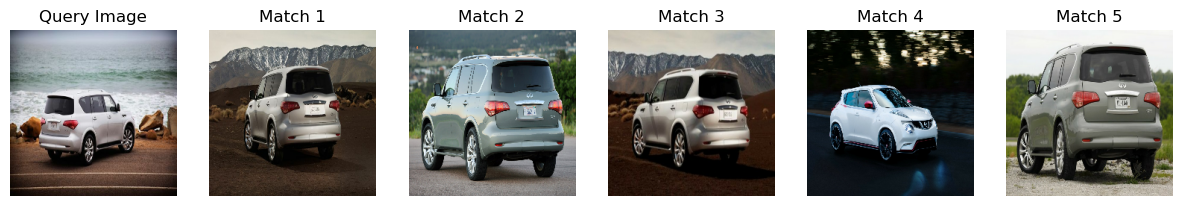

In [29]:
#  **◊§◊ï◊†◊ß◊¶◊ô◊î ◊ú◊î◊¶◊í◊™ ◊™◊û◊ï◊†◊ï◊™ ◊ì◊ï◊û◊ï◊™**
def display_similar_images(query_image_np, similar_indices):
    fig, axes = plt.subplots(1, len(similar_indices) + 1, figsize=(15, 5))
    axes[0].imshow(query_image_np)
    axes[0].set_title("Query Image")
    axes[0].axis("off")
    
    for i, idx in enumerate(similar_indices):
        similar_image_np, _ = train_data[idx]
        axes[i + 1].imshow(similar_image_np)
        axes[i + 1].set_title(f"Match {i+1}")
        axes[i + 1].axis("off")
    
    plt.show()

#  **◊ë◊ì◊ô◊ß◊î: ◊ó◊ô◊§◊ï◊© ◊ï◊î◊¶◊í◊™ ◊™◊û◊ï◊†◊ï◊™ ◊ì◊ï◊û◊ï◊™**
query_image_np, _ = test_data[0]
similar_indices, _ = search_similar_images(query_image_np, top_k=5)
display_similar_images(query_image_np, similar_indices)


In [30]:
# ◊î◊¢◊®◊õ◊™ ◊ê◊ô◊õ◊ï◊™ ◊î◊û◊¢◊®◊õ◊™

In [31]:
#  **◊î◊¢◊®◊õ◊™ ◊î◊ì◊ô◊ï◊ß ◊©◊ú ◊ó◊ô◊§◊ï◊© ◊î◊™◊û◊ï◊†◊ï◊™**
correct_matches = 0
total_queries = len(test_data)

for i in range(total_queries):
    query_image_np, true_label = test_data[i]  #  ◊©◊ï◊ú◊£ ◊ê◊™ ◊î◊™◊û◊ï◊†◊î ◊ï◊î◊™◊ô◊ï◊í ◊î◊ê◊û◊ô◊™◊ô ◊©◊ú◊î ◊û◊™◊ï◊ö ◊î-Test Set.
    similar_indices, _ = search_similar_images(query_image_np, top_k=5)  # 5 ◊î◊õ◊ô ◊ì◊ï◊û◊ï◊™
    retrieved_labels = [image_labels[idx] for idx in similar_indices]  # ◊©◊ï◊ú◊£ ◊™◊ï◊ï◊ô◊ï◊™ ◊©◊ú ◊î◊™◊û◊ï◊†◊ï◊™
    
    if true_label in retrieved_labels:  # ◊ë◊ï◊ì◊ß ◊ê◊ù ◊ê◊ó◊™ ◊û◊î◊™◊û◊ï◊†◊ï◊™ ◊©◊†◊û◊¶◊ê◊ï ◊ë◊ê◊û◊™ ◊©◊ô◊ô◊õ◊™ ◊ú◊ê◊ï◊™◊ï label ◊õ◊û◊ï ◊™◊û◊ï◊†◊™ ◊î◊©◊ê◊ô◊ú◊™◊î.
        correct_matches += 1

accuracy = correct_matches / total_queries
#◊û◊ó◊ú◊ß ◊ê◊™ ◊û◊°◊§◊® ◊î◊î◊™◊ê◊û◊ï◊™ ◊î◊†◊õ◊ï◊†◊ï◊™ ◊ë◊û◊°◊§◊® ◊õ◊ú◊ú ◊î◊©◊ê◊ô◊ú◊™◊ï◊™ ◊õ◊ì◊ô ◊ú◊ó◊©◊ë ◊ê◊™ ◊ì◊ô◊ï◊ß ◊î◊©◊ú◊ô◊§◊î ‚Äì ◊ë◊ô◊ü 0 ◊ú÷æ1.
print(f" ◊ì◊ô◊ï◊ß ◊î◊û◊¢◊®◊õ◊™ (Retrieval Accuracy): {accuracy:.4f}")


‚úÖ ◊ì◊ô◊ï◊ß ◊î◊û◊¢◊®◊õ◊™ (Retrieval Accuracy): 0.8710


# ◊ê◊ô◊ö ◊ú◊ë◊ì◊ï◊ß ◊ê◊ù ◊î◊ó◊ô◊§◊ï◊© ◊ë◊ê◊û◊™ ◊¢◊ï◊ë◊ì?

üîπ ◊™◊û◊ï◊†◊™ ◊î◊©◊ê◊ô◊ú◊™◊î ◊î◊ô◊ê ◊û◊î◊®◊õ◊ë ◊¢◊ù ◊î◊™◊ï◊ï◊ô◊™: 65


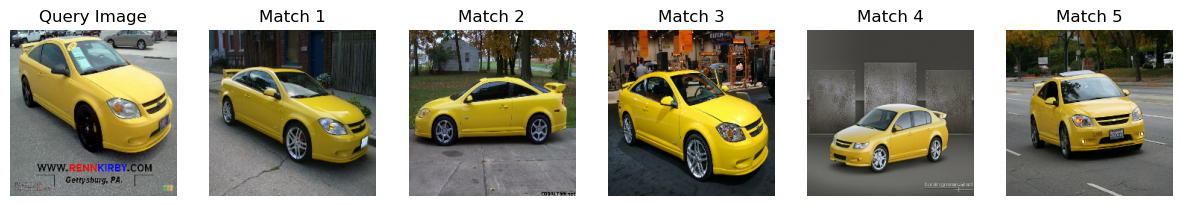

üîπ ◊†◊û◊¶◊ê◊ï ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ì◊ï◊û◊ï◊™ ◊î◊ë◊ê◊ï◊™:
1. ◊™◊û◊ï◊†◊î ◊¢◊ù label 65 (◊û◊®◊ó◊ß: 336.5162)
2. ◊™◊û◊ï◊†◊î ◊¢◊ù label 65 (◊û◊®◊ó◊ß: 391.0938)
3. ◊™◊û◊ï◊†◊î ◊¢◊ù label 65 (◊û◊®◊ó◊ß: 391.1129)
4. ◊™◊û◊ï◊†◊î ◊¢◊ù label 65 (◊û◊®◊ó◊ß: 440.2368)
5. ◊™◊û◊ï◊†◊î ◊¢◊ù label 65 (◊û◊®◊ó◊ß: 485.5797)


In [32]:
import numpy as np

#  ◊ë◊ó◊ô◊®◊™ ◊™◊û◊ï◊†◊î ◊ê◊ß◊®◊ê◊ô◊™ ◊û◊™◊ï◊ö ◊î-Test Set
query_index = np.random.randint(len(test_data))  # ◊ë◊ó◊ô◊®◊î ◊®◊†◊ì◊ï◊û◊ú◊ô◊™ ◊©◊ú ◊™◊û◊ï◊†◊î
query_image_np, true_label = test_data[query_index]  # ◊ò◊¢◊ô◊†◊™ ◊î◊™◊û◊ï◊†◊î ◊ï◊î◊™◊ô◊ï◊í ◊©◊ú◊î

# üîç ◊ó◊ô◊§◊ï◊© ◊™◊û◊ï◊†◊ï◊™ ◊ì◊ï◊û◊ï◊™
similar_indices, distances = search_similar_images(query_image_np, top_k=5)

# üì∏ ◊î◊¶◊í◊™ ◊î◊™◊û◊ï◊†◊î ◊î◊û◊ß◊ï◊®◊ô◊™ ◊ï◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ì◊ï◊û◊ï◊™
print(f"üîπ ◊™◊û◊ï◊†◊™ ◊î◊©◊ê◊ô◊ú◊™◊î ◊î◊ô◊ê ◊û◊î◊®◊õ◊ë ◊¢◊ù ◊î◊™◊ï◊ï◊ô◊™: {true_label}")
display_similar_images(query_image_np, similar_indices)

#  ◊î◊ì◊§◊°◊™ ◊î◊™◊ï◊¶◊ê◊ï◊™ ◊¢◊ù ◊î◊û◊®◊ó◊ß◊ô◊ù ◊û◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ì◊ï◊û◊ï◊™ ◊©◊†◊û◊¶◊ê◊ï
print("üîπ ◊†◊û◊¶◊ê◊ï ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ì◊ï◊û◊ï◊™ ◊î◊ë◊ê◊ï◊™:")
for i, idx in enumerate(similar_indices):
    print(f"{i+1}. ◊™◊û◊ï◊†◊î ◊¢◊ù label {image_labels[idx]} (◊û◊®◊ó◊ß: {distances[i]:.4f})")


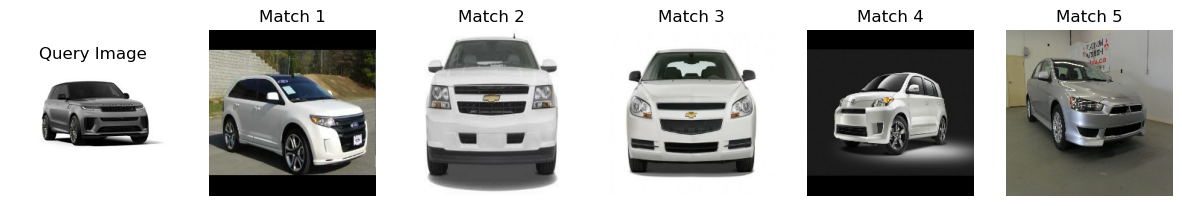

üîπ ◊†◊û◊¶◊ê◊ï ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ë◊ê◊ï◊™:
1. ◊™◊û◊ï◊†◊î ◊¢◊ù label 109 (◊û◊®◊ó◊ß: 573.6252)
2. ◊™◊û◊ï◊†◊î ◊¢◊ù label 61 (◊û◊®◊ó◊ß: 579.0670)
3. ◊™◊û◊ï◊†◊î ◊¢◊ù label 66 (◊û◊®◊ó◊ß: 600.4886)
4. ◊™◊û◊ï◊†◊î ◊¢◊ù label 177 (◊û◊®◊ó◊ß: 604.5338)
5. ◊™◊û◊ï◊†◊î ◊¢◊ù label 166 (◊û◊®◊ó◊ß: 605.5303)


In [34]:
#  **◊ò◊¢◊ô◊†◊™ ◊™◊û◊ï◊†◊î ◊ó◊ô◊¶◊ï◊†◊ô◊™ ◊ï◊ë◊ô◊¶◊ï◊¢ ◊ó◊ô◊§◊ï◊©**
external_image_path = r"C:\Users\revit\Documents\Data Learning\Project2\range_rover.jpeg"  # ◊¢◊ì◊õ◊ï◊ü ◊ë◊î◊™◊ê◊ù ◊ú◊°◊ô◊ï◊û◊™

# ◊ß◊®◊ô◊ê◊™ ◊î◊™◊û◊ï◊†◊î ◊î◊ó◊ô◊¶◊ï◊†◊ô◊™
external_image = Image.open(external_image_path).convert("RGB")
external_image_np = np.array(external_image)

# ◊ó◊ô◊§◊ï◊© ◊™◊û◊ï◊†◊ï◊™ ◊ì◊ï◊û◊ï◊™
similar_indices, distances = search_similar_images(external_image_np, top_k=5)

# ◊î◊¶◊í◊™ ◊î◊™◊ï◊¶◊ê◊ï◊™
display_similar_images(external_image_np, similar_indices)

print("üîπ ◊†◊û◊¶◊ê◊ï ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ë◊ê◊ï◊™:")
for i, idx in enumerate(similar_indices):
    print(f"{i+1}. ◊™◊û◊ï◊†◊î ◊¢◊ù label {image_labels[idx]} (◊û◊®◊ó◊ß: {distances[i]:.4f})")


In [ ]:
# ◊ë◊ì◊ô◊ß◊î ◊¢◊ú 3 ◊™◊û◊ï◊†◊ï◊™ 

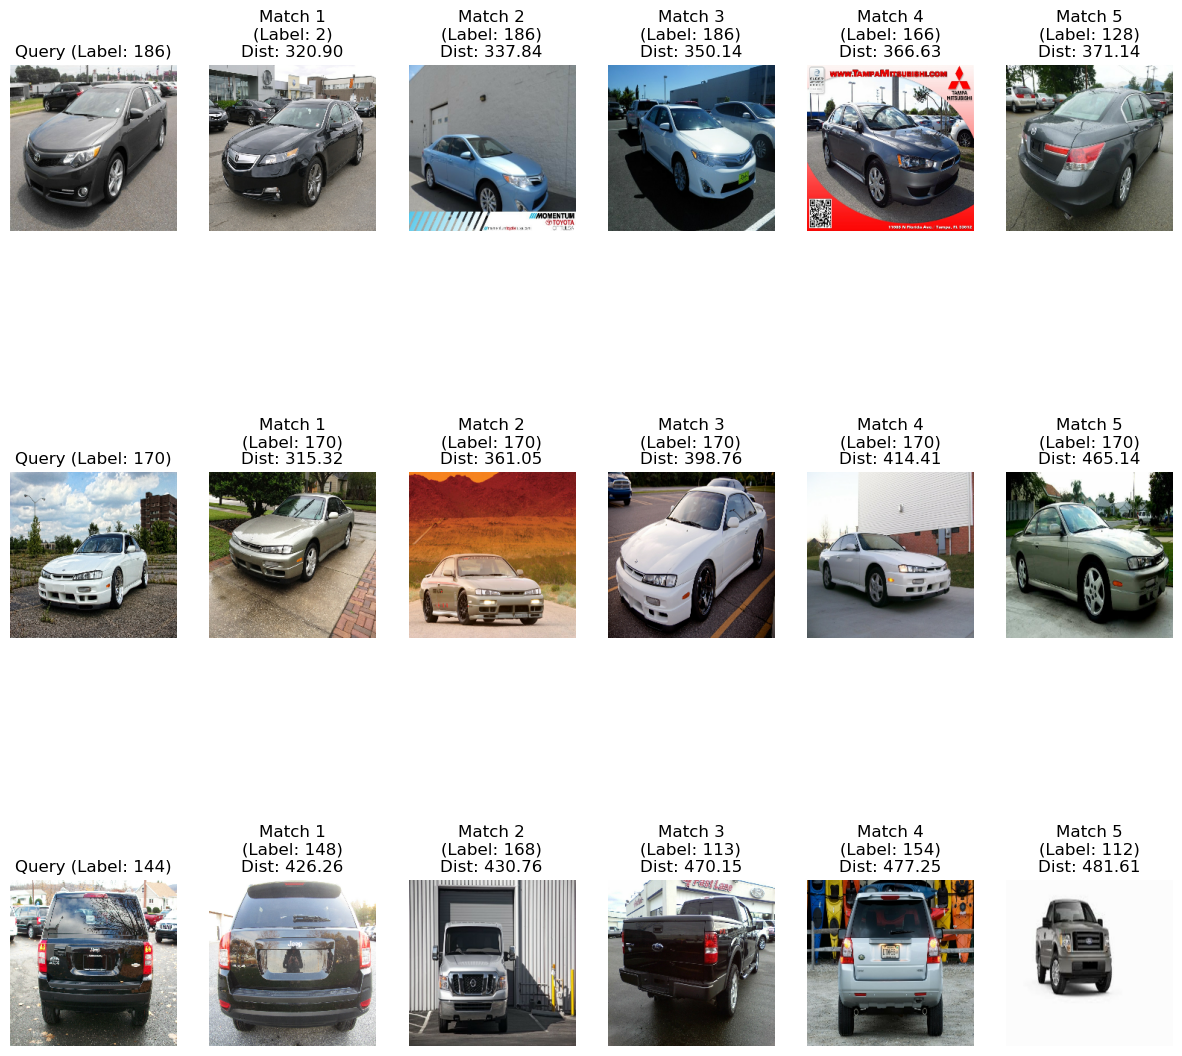

In [40]:
import random

#  **◊§◊ï◊†◊ß◊¶◊ô◊î ◊ú◊î◊¶◊í◊™ ◊û◊°◊§◊® ◊™◊û◊ï◊†◊ï◊™ ◊©◊ê◊ô◊ú◊™◊ê ◊¢◊ù ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ì◊ï◊û◊ï◊™ ◊ú◊î◊ü**
def display_multiple_queries(test_data, num_queries=3, top_k=5):
    """
    ◊û◊¶◊ô◊í◊î num_queries ◊™◊û◊ï◊†◊ï◊™ ◊û◊™◊ï◊ö ◊î-Test Set ◊ô◊ó◊ì ◊¢◊ù ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ì◊ï◊û◊ï◊™ ◊ú◊î◊ü.
    """
    # ◊ë◊ó◊ô◊®◊™ num_queries ◊™◊û◊ï◊†◊ï◊™ ◊ê◊ß◊®◊ê◊ô◊ï◊™ ◊û◊™◊ï◊ö ◊î-Test Set
    query_samples = random.sample(test_data, num_queries)
    
    fig, axes = plt.subplots(num_queries, top_k + 1, figsize=(15, 5 * num_queries))

    for row, (query_image_np, true_label) in enumerate(query_samples):
        similar_indices, distances = search_similar_images(query_image_np, top_k=top_k)

        # ◊î◊¶◊í◊™ ◊î◊™◊û◊ï◊†◊î ◊î◊û◊ß◊ï◊®◊ô◊™
        axes[row, 0].imshow(query_image_np)
        axes[row, 0].set_title(f"Query (Label: {true_label})")
        axes[row, 0].axis("off")

        # ◊î◊¶◊í◊™ ◊î◊™◊û◊ï◊†◊ï◊™ ◊î◊ì◊ï◊û◊ï◊™
        for col, idx in enumerate(similar_indices):
            similar_image_np, retrieved_label = train_data[idx]
            axes[row, col + 1].imshow(similar_image_np)
            axes[row, col + 1].set_title(f"Match {col+1}\n(Label: {retrieved_label})\nDist: {distances[col]:.2f}")
            axes[row, col + 1].axis("off")

    plt.show()

# **◊ë◊ì◊ô◊ß◊î: ◊î◊¶◊í◊™ 3 ◊™◊û◊ï◊†◊ï◊™ ◊©◊ê◊ô◊ú◊™◊ê ◊¢◊ù 5 ◊î◊î◊™◊ê◊û◊ï◊™ ◊î◊ì◊ï◊û◊ï◊™ ◊ë◊ô◊ï◊™◊®**
display_multiple_queries(test_data, num_queries=3, top_k=5)


In [ ]:
# ◊î◊¢◊®◊õ◊™ ◊ì◊ô◊ï◊ß

In [41]:
#  **◊î◊¢◊®◊õ◊™ ◊î◊ì◊ô◊ï◊ß ◊©◊ú ◊ó◊ô◊§◊ï◊© ◊î◊™◊û◊ï◊†◊ï◊™**
correct_matches = 0
total_queries = len(test_data)

for i in range(total_queries):
    query_image_np, true_label = test_data[i]
    similar_indices, _ = search_similar_images(query_image_np, top_k=5)
    retrieved_labels = [image_labels[idx] for idx in similar_indices]
    
    if true_label in retrieved_labels:
        correct_matches += 1

accuracy = correct_matches / total_queries
print(f" ◊ì◊ô◊ï◊ß ◊î◊û◊¢◊®◊õ◊™ (Retrieval Accuracy): {accuracy:.4f}")

‚úÖ ◊ì◊ô◊ï◊ß ◊î◊û◊¢◊®◊õ◊™ (Retrieval Accuracy): 0.8710
